# Feature Pipeline

## Creating Features from Individual Words and N-Grams

July 3, 2019

## Table of Contents



<a id="1"></a>
## Library, Module and Data Imports

In [2]:
# Imports

# Standard Libraries
from itertools import combinations

# Numerical Libraries
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Visual Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Local Package Libraries
import sys
sys.path.append("../..")

from src.data.make_dataset import *
from src.features.general_helper_functions import *
from src.features.text_cleaning import *

In [3]:
# Settings

# Stop the warnings for chain in pandas...
pd.options.mode.chained_assignment = None

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

%matplotlib inline

In [4]:
# raw data import
_, watchlist_raw, stock_prices_raw = get_raw_data()
article_raw = clean_and_open_business_wire_data_01(None)

In [5]:
# Base data cleaning and formatting
articles = article_raw.copy()
articles.reset_index(inplace=True)
articles.time = pd.to_datetime(articles.time)

watchlist = watchlist_raw.copy()

<a id="2"></a>

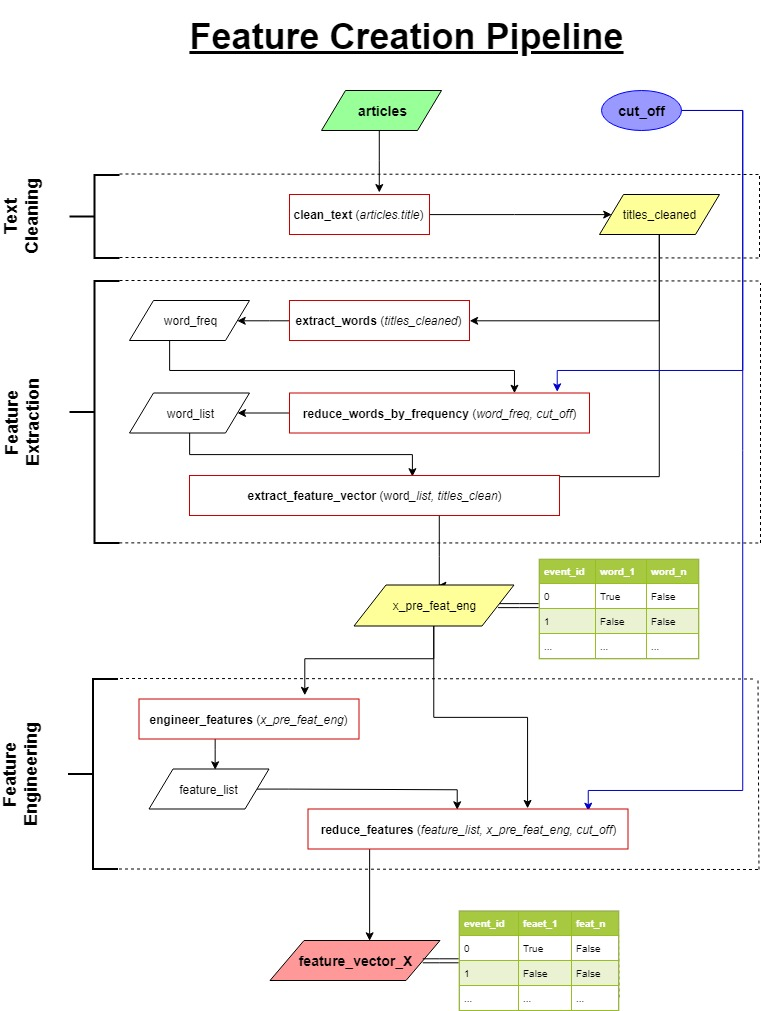

In [9]:
Image("../../reports/figures/NewsArticle_FeatureCreationPipeline_v2.jpg", width=600)

<a id="2.1"></a>
### Text Cleaning

In [10]:
def preprocess_text_data(articles_full, watchlist, column_name="title"):
    unique_companies = articles_full.ticker.unique()

    # General text cleaning
    cleaned_text = clean_text(articles_full, column_name)[column_name]

    # Remove company name from title
    company_names = watchlist.loc[watchlist.Ticker.isin(unique_companies)].index.tolist()
    return cleaned_text.apply(remove_company_name, args=(company_names,))

In [11]:
titles_cleaned = preprocess_text_data(articles, watchlist, "title")

In [28]:
titles_cleaned.shape

(8433,)

<a id="2.2"></a>
### Feature Extraction

<a id="2.2.1"></a>
#### Extract Words

In [18]:
def extract_words(text_series):
    full_text_corpus = merge_text(text_series)
    
    unique_words = filter_unique_words(full_text_corpus)
    
    return get_token_frequency_dict(unique_words, text_series)

def merge_text(texts):
    return " ".join(texts.values)

def filter_unique_words(corpus):
    return set(corpus.split(" "))

def get_token_frequency_dict(token_set, texts):
    return {token: get_token_frequency(token, texts) for token in token_set}

def get_token_frequency(token, texts):
    return sum([1 if token in text else 0 for text in texts.values])/texts.shape[0]

In [19]:
word_freq = extract_words(titles_cleaned)
print(len(word_freq))

7610


<a id="2.2.2"></a>
#### Reduce Number of Words

In [20]:
def reduce_words_by_freq(word_frequency, cut_off=0.01):
    return [word for word in word_frequency.keys() if word_frequency[word] > cut_off]

def remove_short_strings(word_list, min_length=4):
    return [word for word in word_list if len(word) > min_length]

In [21]:
cut_off = 0.015

word_list = remove_short_strings(reduce_words_by_freq(word_freq, cut_off))

In [22]:
len(word_list)

98

<a id="2.2.5"></a>
#### Extract Feature Vectors

In [23]:
def extract_feature_vectors(text_series, features):
    return pd.DataFrame({ind: extract_features_boolean(text, features) for ind, text in text_series.iteritems()}, index=features).T

def extract_features_boolean(text, features):
    return [True if feature in text.split(" ") else False for feature in features]

In [25]:
features = extract_feature_vectors(titles_cleaned, word_list)

In [26]:
features.head()

,industry,device,result,comme,financial,insight,annual,treat,state,patient,...,older,investor,offer,growth,system,agnostic,contact,diagnostics,development,appoint
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Collecting Functions into a Transormation Object

In [30]:
class FeatureExtraction:
    def __init__(self, min_str_length=4):
        self.cut_off = 0
        self.min_str_length = min_str_length
        self.word_list = []
        
    def fit(self, X, cut_off=0.01):
        self.cut_off = cut_off
        word_freq = extract_words(X)
        words_reduced_by_freq = reduce_words_by_freq(word_freq, self.cut_off)
        self.word_list += remove_short_strings(words_reduced_by_freq, self.min_str_length)
    
    def transform(self, X):
        return extract_feature_vectors(X, self.word_list)
    
    def fit_transform(self, X, cut_off=0.01,):
        self.fit(X, cut_off)
        return self.transform(X)

In [31]:
feat_extractor = FeatureExtraction()

x_pre_feat_eng = feat_extractor.fit_transform(titles_cleaned)

x_pre_feat_eng.head()

,industry,device,result,comme,financial,insight,annual,treat,state,patient,...,president,order,agnostic,contact,genetic,vendor,diagnostics,drive,development,appoint
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<a id="2.3"></a>
### Feature Engineering

<a id="2.2.3"></a>
#### Engineer Features

In [62]:
def engineer_features(words, max_num_grams_per_token=2):
    tokens = []
    
    if max_num_grams_per_token is not None:
        for n in range(2, max_num_grams_per_token+1):
            tokens += get_ngrams(words, n)
        
    return [tok for tok in tokens if type(tok) != str]

def get_ngrams(words, n):
    return combinations(words, n)

In [63]:
max_n = 2 # For this trial, simply will get the individual words

new_feature_list = engineer_features(word_list, max_n)

In [64]:
len(new_feature_list), new_feature_list[0]

(4753, ('industry', 'device'))

In [76]:
def extract_new_feature_vectors(new_feats, x_pre_eng):
    return pd.DataFrame({ind: extract_features_boolean(row, new_feats) for ind, row in x_pre_eng.iterrows()}, index=new_feats).T

def extract_features_boolean(row, features):
    return [extract_tuple_boolean(row, feature) for feature in features]

def extract_tuple_boolean(row, feature):
    return all([row[token] for token in feature])

In [77]:
x_pre_feat_red = extract_new_feature_vectors(new_feature_list, x_pre_feat_eng)

x_pre_feat_red.head()

,"(industry, device)","(industry, result)","(industry, comme)","(industry, financial)","(industry, insight)","(industry, annual)","(industry, treat)","(industry, state)","(industry, patient)","(industry, strategic)",...,"(agnostic, contact)","(agnostic, diagnostics)","(agnostic, development)","(agnostic, appoint)","(contact, diagnostics)","(contact, development)","(contact, appoint)","(diagnostics, development)","(diagnostics, appoint)","(development, appoint)"
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<a id="2.3.3"></a>
#### Collecting Functions into a Transformation Object

In [102]:
class FeatureEngineering:
    def __init__(self, max_n_grams=2):
        self.max_n_grams = max_n_grams
        self.new_feature_list = []
        
    def fit(self, x):
        self.new_feature_list = engineer_features(x.columns.tolist(), max_n)
    
    def transform(self, x):
        return extract_new_feature_vectors(self.new_feature_list, x)
    
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

In [103]:
feat_engineer = FeatureEngineering()

x_pre_feat_red = feat_engineer.fit_transform(x_pre_feat_eng)

x_pre_feat_red.head()

,"(industry, device)","(industry, result)","(industry, comme)","(industry, financial)","(industry, insight)","(industry, annual)","(industry, treat)","(industry, state)","(industry, patient)","(industry, advance)",...,"(vendor, diagnostics)","(vendor, drive)","(vendor, development)","(vendor, appoint)","(diagnostics, drive)","(diagnostics, development)","(diagnostics, appoint)","(drive, development)","(drive, appoint)","(development, appoint)"
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<a id="2.4"></a>
### Feature Reduction

<a id="2.4.1"></a>
#### Reduction by Frequency

In [105]:
def reduce_features_by_frequency(x, cut_off_value):

    features_filtered = x.sum().loc[x.sum() > cut_off_value].index

    return x[features_filtered]

In [96]:
cut_off_value = cut_off * x.shape[0]

x_post_feat_red = reduce_features_by_frequency(x_pre_feat_red, cut_off_value)
x_post_feat_red.shape

(8433, 110)

<a id="2.4.2"></a>
#### Combine Feature Sets

In [95]:
def combine_features(list_of_features):
    return pd.concat(list_of_features, axis=1)

In [97]:
x = combine_features([x_pre_feat_eng, x_post_feat_red])

x.shape

(8433, 262)

<a id="2.4.3"></a>
#### Collecting Functions into a Transformation Object

In [111]:
class FeatureReduction:
    def __init__(self):
        self.cut_off = 0
        self.cut_off_value = 0
        
    def fit(self, num_samples, cut_off=0.01):
        self.cut_off_value = self.cut_off * num_samples
        self.cut_off = cut_off
    
    def transform_individual(self, feature_set):
        return(reduce_features_by_frequency(feature_set, self.cut_off_value))
               
    def transform_batch(self, list_feature_sets):
        return combine_features([self.transform_individual(feature_set) for feature_set in list_feature_sets])
    
    def fit_transform(self, x, cut_off=0.01):
        if type(x) == list:
            num_samples = sum([list_item.shape[1] for list_item in x])
            self.fit(num_samples, cut_off)
            return self.transform_batch(x)
        
        else:
            num_sample = x.shape[1]
            self.fit(x, cut_off)
            return self.transform_individual(x)

In [112]:
feature_reducer = FeatureReduction()

x_post_reduction = feature_reducer.fit_transform([x_pre_feat_eng, x_post_feat_red], 0.01)

<a id="2.3"></a>
### Output

In [114]:
x.shape

(8433, 262)

In [115]:
x_post_reduction.shape

(8433, 262)

<a id="3"></a>
## (Brief) Data Exploration

In [99]:
feature_corr = x.corr()

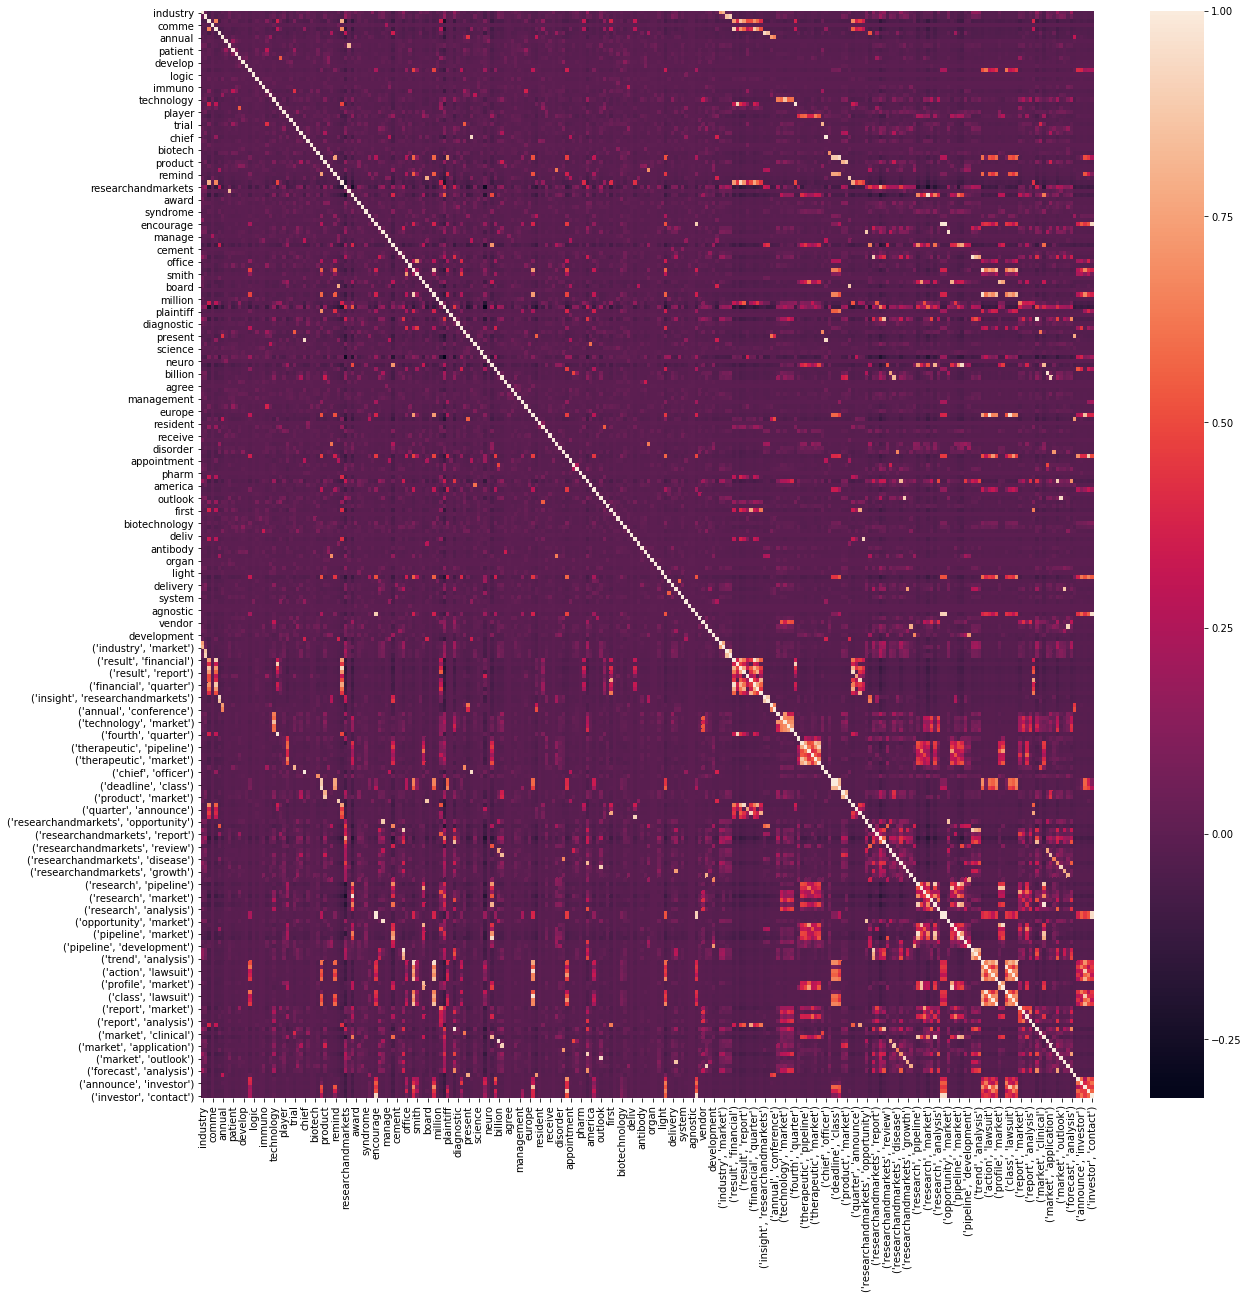

In [100]:
fig, ax = plt.subplots(figsize=(20, 20))
_ = sns.heatmap(feature_corr, ax=ax)

I find it interesting that there isn't very many highly correlated pairs in the data. That is potentially great! That should give a better chance of finding some interested data.

The next steps for tomorrow will be to push this into some production code with the ability to save and open the data after pushing through the pipeline.

## Full Pipeline

In [2]:
class FeatureCreationPipeline:
    def __init__(self):
        self.cut_off = 0
        self.feat_extractor = FeatureExtraction()
        self.feat_engineer = FeatureEngineering()
        self.feature_reducer = FeatureReduction()
        
        self.x = None
        
    def fit_transform(self, articles, watchlist, cut_off=None):
        if cut_off is not None:
            self.cut_off = cut_off
            
        titles_cleaned = preprocess_text_data(articles, watchlist, "title")
        x_pre_feat_eng = feat_extractor.fit_transform(titles_cleaned, cut_off)
        x_pre_feat_red = feat_engineer.fit_transform(x_pre_feat_eng)
        
        self.x = feature_reducer.fit_transform([x_pre_feat_eng, x_post_feat_red], cut_off)